In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

import numpy as np
import wfdb
import pywt
import os

In [2]:
sig_len = 1280

#### Helper Function

In [3]:
# Function to read the data from a given path to the .hea file
def read_data(path,type):
    signals, fields = wfdb.rdsamp(path,sampfrom=0)
    if(type=="normal"):
        data_array = signals.T[1]
    if(type=="cad"):
        data_array = signals.T[0]

    # Returns a data array of length that is a multiple of sig_len
    return data_array[:sig_len*int(data_array.shape[0]/sig_len)]

# Does wavelet transform to denoise the entire data array
def wavelet_transform(data_array):
    coefficient = pywt.wavedec(data_array,wavelet='db6',level=5)
    coefficient[0] = np.zeros_like(coefficient[0])
    transformed_signal = pywt.waverec(coefficient,wavelet='db6')

    data_array = transformed_signal

# Reshapes data array such that each row becomes signal segment of length sig_len
def reshape_data(data_array):
    return data_array.reshape(int(data_array.shape[0]/sig_len),sig_len)

# Does the preprocessing on the data segment of length sig_len
def augment_signal(data_array):
    # Normalization
    data_array = np.array((data_array-np.mean(data_array))/np.std(data_array))

    # Generate random sinusoidal noise signal
    starting_phase = np.random.uniform(-180, -90)
    # ending_phase = np.random.uniform(90, 180)      # I am not using this ending phase part here
    amplitude = np.random.uniform(-2, 2)
    time = np.arange(data_array.shape[0])  
    sinusoidal_noise_signal = amplitude * np.sin(2 * np.pi * time + np.radians(starting_phase))

    # Generate random Gaussian noise signal
    gaussian_noise_signal = np.random.normal(0, 0.05, len(data_array))

    data_array = data_array + sinusoidal_noise_signal + gaussian_noise_signal

# Converts the linear signal of shape (1280,) to an image of shape(211,24)
def make_img(data_array):
    result = []
    idx=0
    for i in range(0,24):
        result.append(data_array[idx:idx+211])
        idx+=40

    return np.array(result).T

#### Reading the data

In [4]:
# Path to the data files
# Path to CAD ECG data
path1 = r"C:\Users\123na\Downloads\Heart Disease prediction\Data\CAD"
# Path to normal ECG data
path2 = r"C:\Users\123na\Downloads\Heart Disease prediction\Data\fantasia-database-1.0.0" 

list1 = os.listdir(path1)    # File list in directory at path1
list2 = os.listdir(path2)    # File list in directory at path2

list1 = [x for x in list1 if x[-4:]==".hea"]         # files in list1 ending with ".hea"
list1 = [x[:3] for x in list1]                       # removes ".hea" from files names in list1
path_cad = [os.path.join(path1,x) for x in list1]    # joins path1 with filenames in list1

list2 = [x for x in list2 if x[-4:]==".hea"]         # files in list2 ending with ".hea"
list2 = [x[:5] for x in list2]                       # removes ".hea" from files names in list2
path_normal = [os.path.join(path2,x) for x in list2] # joins path2 with filenames in list2

In [5]:
import random
path_cad = random.sample(path_cad,6)         # Picking 6 random samples from CAD diagnosed data
path_normal = random.sample(path_normal,6)   # Picking 6 random samples from normal data 

#### Visualisation

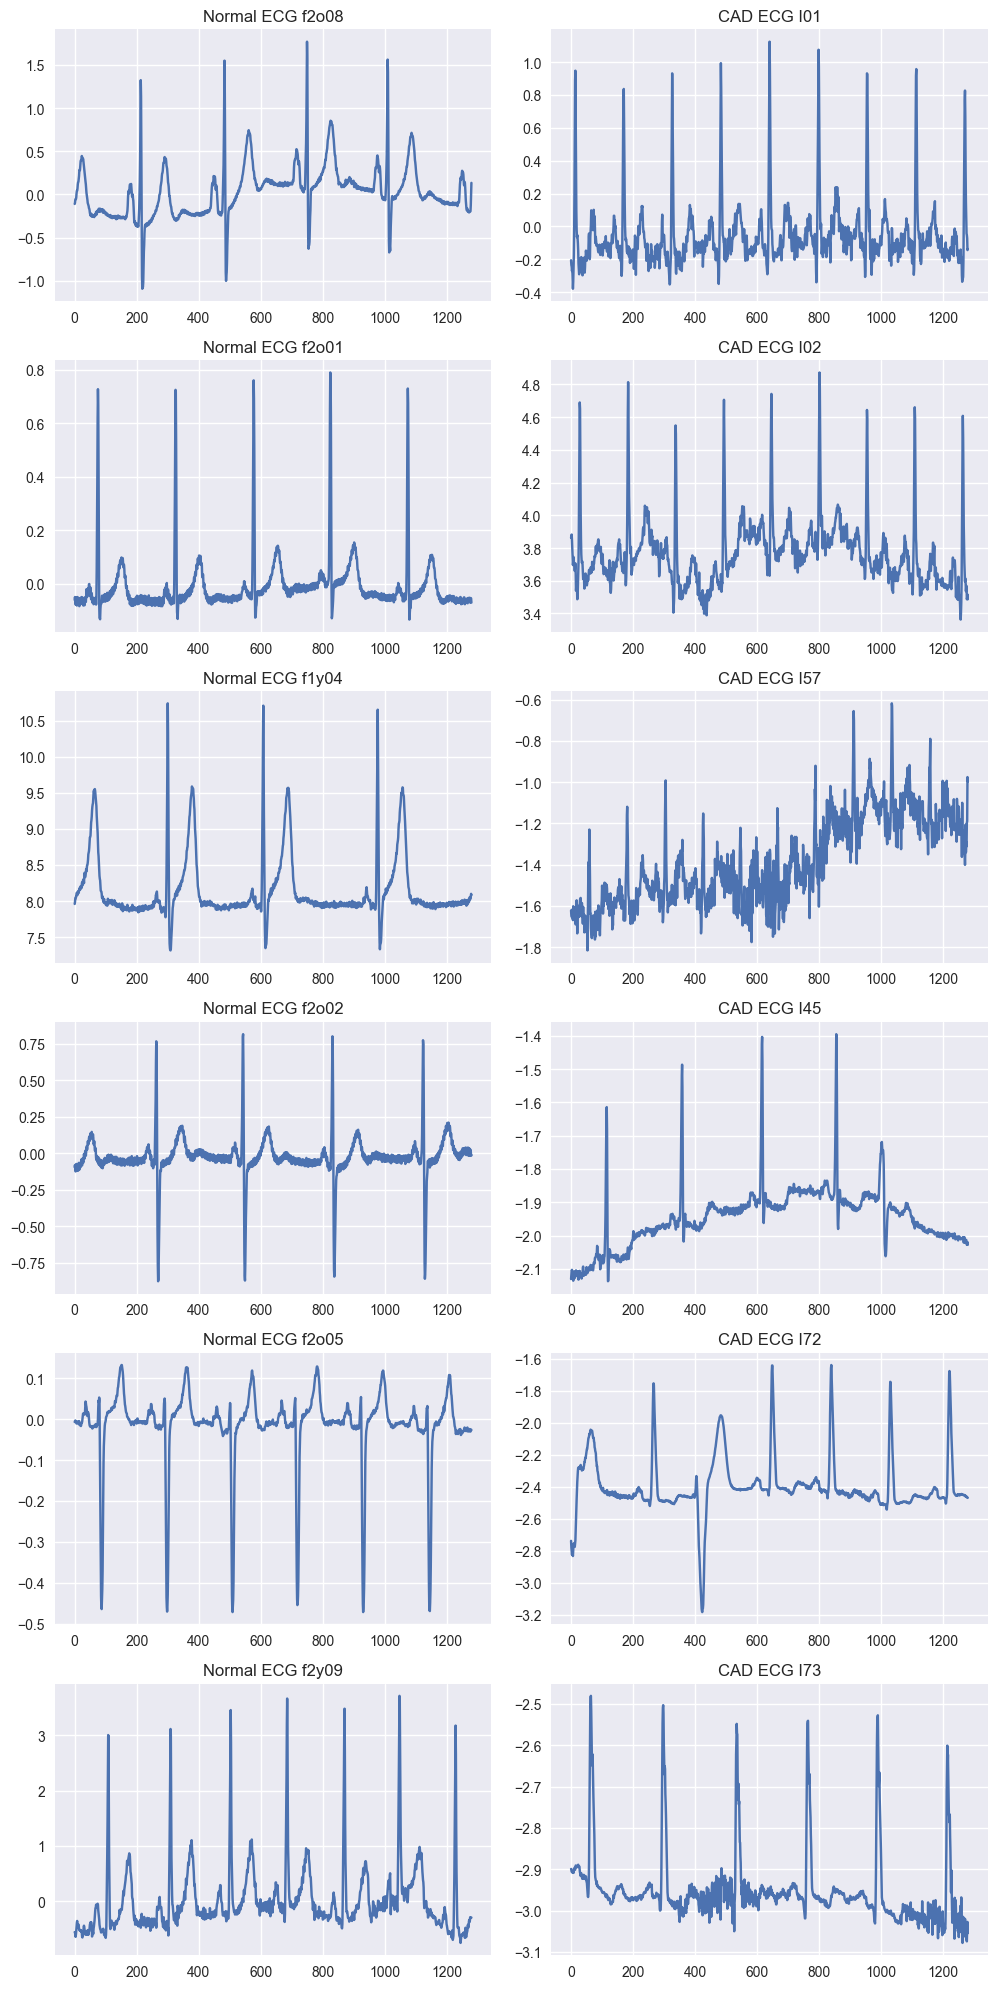

In [6]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))

for i in range(6):
    data1 = read_data(path_normal[i], type="normal")
    data2 = read_data(path_cad[i], type="cad")
    
    axs[i, 0].plot(data1[500*1280:501*1280], label="Normal ECG")
    axs[i, 0].set_title("Normal ECG "+str(path_normal[i][-5:]))
    
    axs[i, 1].plot(data2[100*1280:101*1280], label="CAD ECG")
    axs[i, 1].set_title("CAD ECG "+str(path_cad[i][-3:]))

plt.tight_layout()
plt.show()

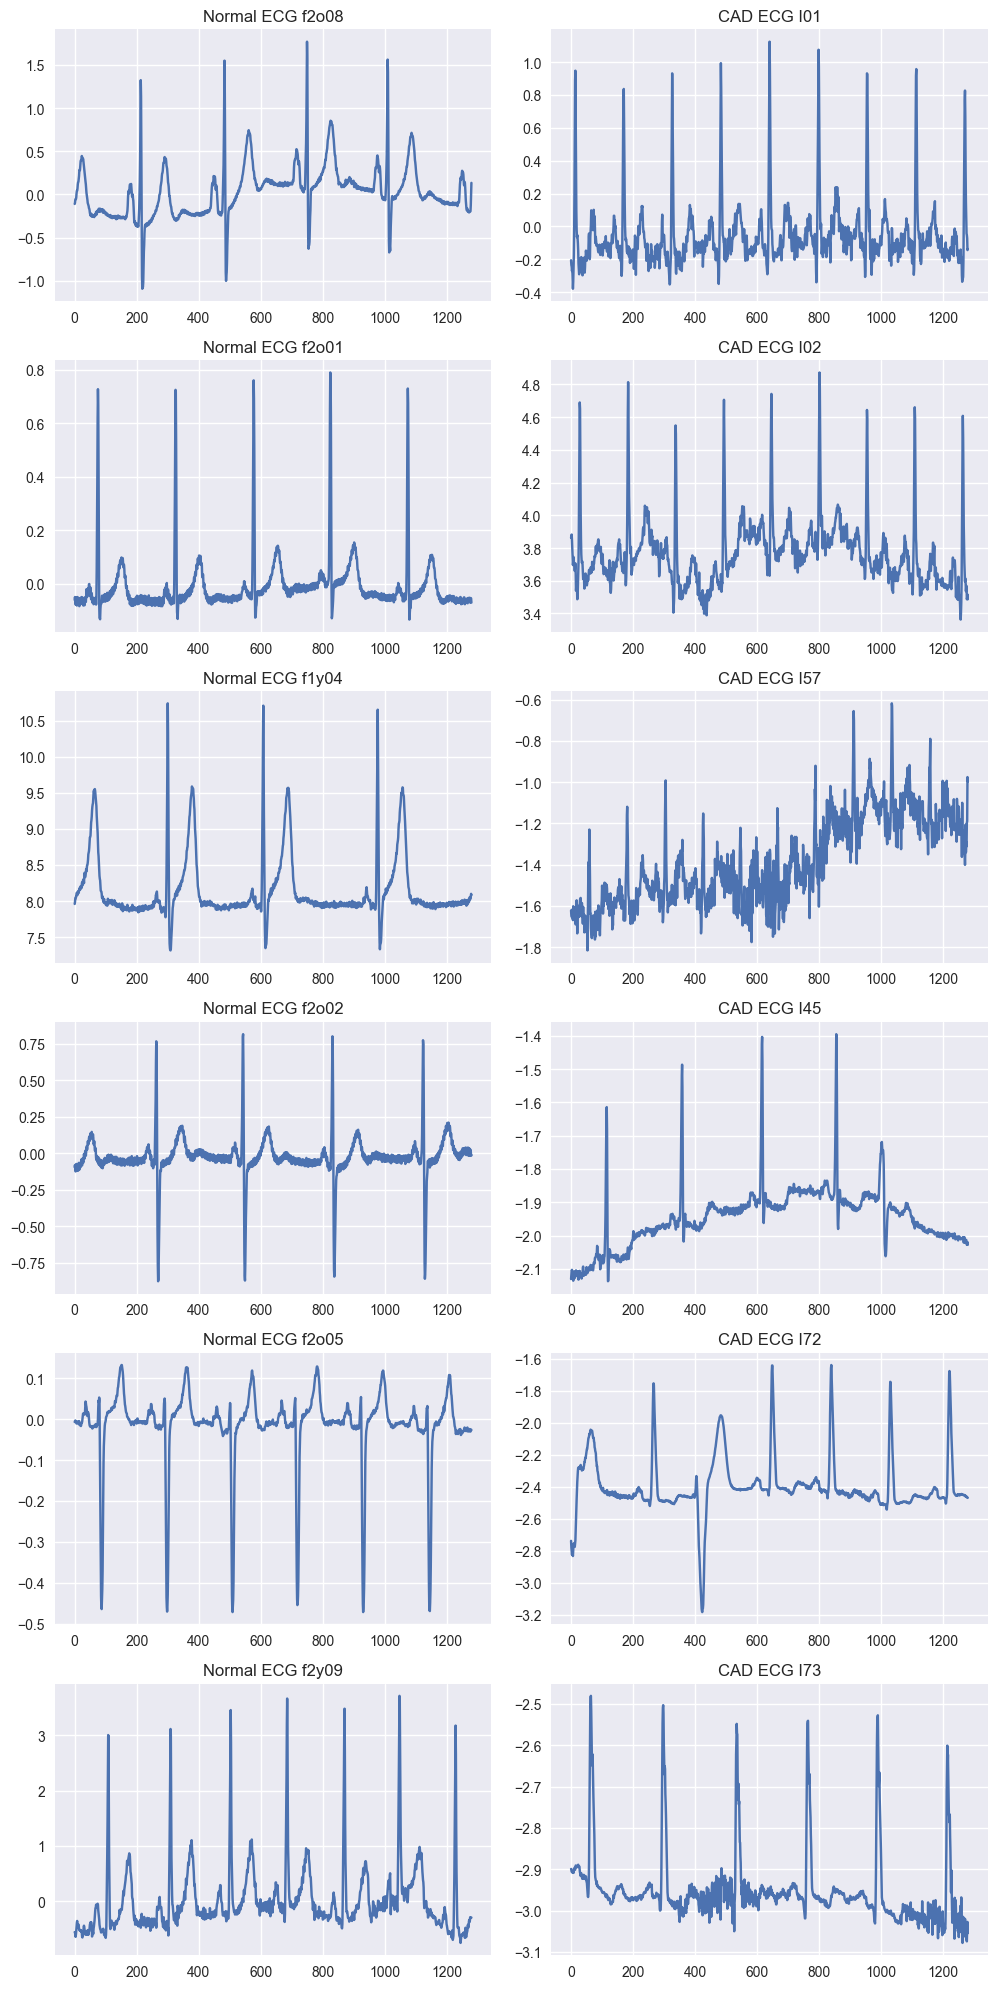

In [7]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))

for i in range(6):
    data1 = read_data(path_normal[i], type="normal")
    data2 = read_data(path_cad[i], type="cad")

    wavelet_transform(data1)
    wavelet_transform(data2)
    
    axs[i, 0].plot(data1[500*1280:501*1280], label="Normal ECG")
    axs[i, 0].set_title("Normal ECG "+str(path_normal[i][-5:]))
    
    axs[i, 1].plot(data2[100*1280:101*1280], label="CAD ECG")
    axs[i, 1].set_title("CAD ECG "+str(path_cad[i][-3:]))

plt.tight_layout()
plt.show()

In [8]:
# Reading the data seperately to pick the proportion of the CAD and normal data 

# Reading the CAD data first
cad_data = []
for i, idx in enumerate(path_cad):
    # Read the data
    data = read_data(idx,type="cad")

    # Performing wavelet transform on the entire data
    wavelet_transform(data)

    #Reshape data array
    data = reshape_data(data)
    temp = []
    for row in data:
        augment_signal(row)
        image = make_img(row)
        if(np.sum(np.isnan(image))==0): # We are getting some NaN values while reading data, we would just ignore data points that has NaN values
            temp.append(image)
    cad_data.append(np.array(temp))

cad_data = np.array(cad_data)



# Reading the normal data
normal_data = []
for i, idx in enumerate(path_normal):
    # Read the data
    data = read_data(idx,type="normal")

    # Performing wavelet transform on the entire data
    wavelet_transform(data)

    #Reshape data array
    data = reshape_data(data)
    temp = []
    for row in data:
        augment_signal(row)
        image = make_img(row)
        if(np.sum(np.isnan(image))==0):  # We are getting some NaN values while reading data, we would just ignore those NaN producing elements
            temp.append(image)
    normal_data.append(np.array(temp))

normal_data = np.array(normal_data)

C:\Users\123na\AppData\Local\Temp\ipykernel_16332\3670626204.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normal_data = np.array(normal_data)


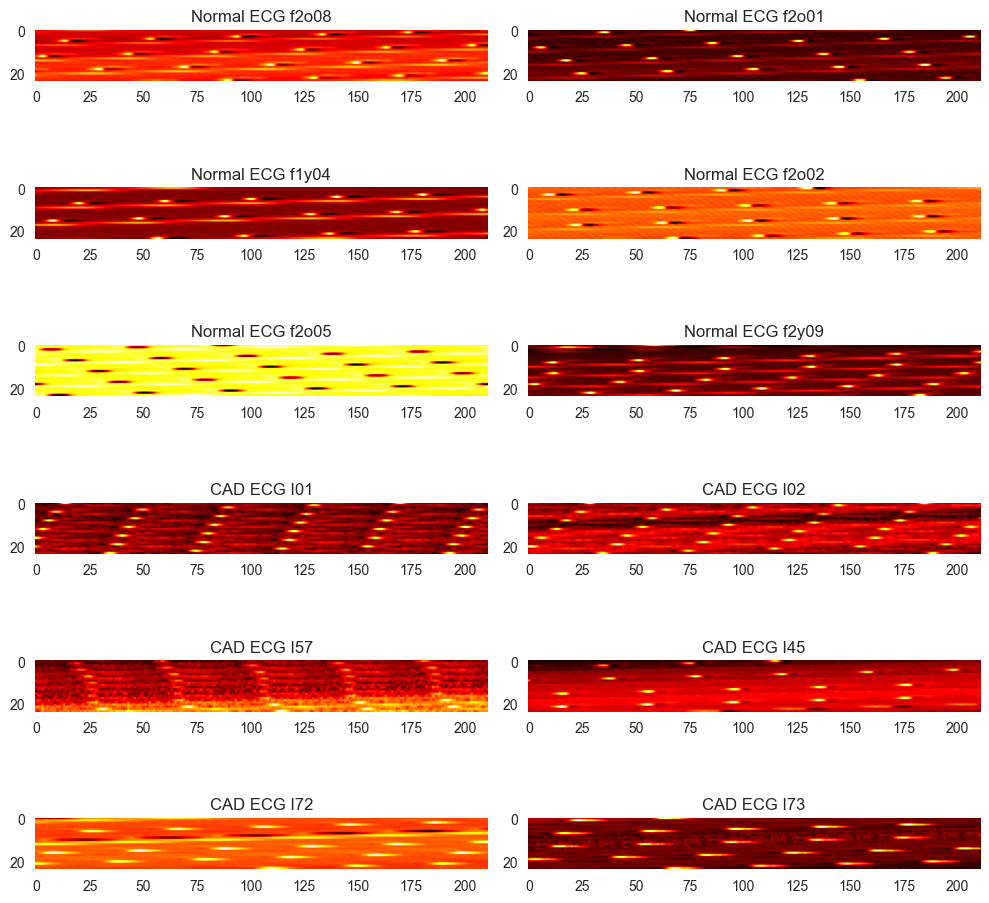

In [9]:
fig, axs = plt.subplots(figsize=(10, 10))
plt.subplots_adjust(hspace=0.05)

for i in range(6):
    plt.subplot(6,2,i+1)
    plt.imshow(normal_data[i][500].T, cmap="hot", label="Normal ECG")
    plt.title("Normal ECG "+str(path_normal[i][-5:]))
    plt.grid(False)

    plt.subplot(6,2,i+7)
    plt.imshow(cad_data[i][100].T, cmap="hot", label="CAD ECG")
    plt.title("CAD ECG "+str(path_cad[i][-3:]))
    plt.grid(False)
    
plt.tight_layout()
plt.show()